## Реализация VAE

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import keras.backend as K
from keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout
from keras.models import Model

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [59]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

hidden_size - размерность скрытого пространства / кол-во нейронов  
т.е вектор скрытого пространства имеет 2 элемента (для отображения на плоскости).

В функции <b><code>noiser</code></b> используется <code>exp(z_ln_var / 2)</code>, что бы преобразовать <code>z_ln_var</code> (логарифм дисперсии) в стандартное отклонение.


In [76]:
hidden_size = 2
batch_size = 60 # должно быть кратно 60 000


def dropoutAndBatch(x):
    return Dropout(0.3)(BatchNormalization()(x))


def noiser(args):
    """
    z_mean - МО
    z_ln_var - логорифм дисперсии ln(sigma^2)
    """
    global z_mean, z_ln_var
    z_mean, z_ln_var = args
    N = K.random_normal(shape=(batch_size, hidden_size), mean=0., stddev=1.0)
    return K.exp(z_ln_var / 2) * N + z_mean


# кодер
input_img = Input((28, 28, 1))
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = dropoutAndBatch(x)
x = Dense(128, activation='relu')(x)
x = dropoutAndBatch(x)

z_mean = Dense(hidden_size)(x)
z_ln_var = Dense(hidden_size)(x)

h = Lambda(noiser, output_shape=(hidden_size,))([z_mean, z_ln_var])

# декодер
input_dec = Input(shape=(hidden_size,))
d = Dense(128, activation='relu')(input_dec)
d = dropoutAndBatch(d)
d = Dense(256, activation='relu')(d)
d = dropoutAndBatch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28,28,1))(d)

encoder = Model(input_img, h, name='encoder')
decoder = Model(input_dec, decoded, name='decoder')
vae = Model(input_img, decoder(encoder(input_img)), name='vae')

Формула Кульбака-Лейблера, для данного случая (нормального распределения), будет такой:  

$ \frac{1}{2} * (tr(\sum_G) + \mu _G ^T * \mu _G - k - ln(det \sum _G))$

Но если упросить еще:  

$ ln(det \sum _G) = ln(\sigma _1 ^2, \sigma _2 ^2, \sigma _3 ^2, ..., \sigma _k ^2) = \sum _{i=1} ^k ln(\sigma _i ^2)$

$ \mu _G ^T * \mu _G = \sum _{i=1} ^k \mu _i ^2$

$ tr(\sum_G) = \sum _{i=1} ^k \sigma _i ^2 $

В итоге получим:  
$ -0.5 * (k + \sum _{i=1} ^{k} (ln(\sigma _i ^2) - \mu _i ^2 - \sigma _i ^2)) $

In [77]:
def vae_loss(x, y):
    x = K.reshape(x, shape=(batch_size, 28*28))
    y = K.reshape(y, shape=(batch_size, 28*28))
    loss = K.sum(K.square(x-y), axis=-1)
    kl_los = -0.5 * K.sum(1 + z_ln_var - K.square(z_mean) - K.exp(z_ln_var), axis=-1) # дивергенция Кульбака-Лейблера
    return loss + kl_los


vae.compile(optimizer='Adam', loss=vae_loss)

In [78]:
vae.fit(x_train, x_train, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5
1000/1000 [==============================] - 6s 5ms/step - loss: 62.9396
Epoch 2/5
1000/1000 [==============================] - 4s 4ms/step - loss: 45.0303
Epoch 3/5
1000/1000 [==============================] - 4s 4ms/step - loss: 43.8930
Epoch 4/5
1000/1000 [==============================] - 4s 4ms/step - loss: 43.2983
Epoch 5/5
1000/1000 [==============================] - 5s 5ms/step - loss: 42.7933


Распределение точек векторов скрытого состояния для тестового набора изображений.  
Теперь данные представлены областью с нормальным распределением.

Можем брать любые точки из этой области и должны получать осмысленные изображения.

100/100 [==============================] - 0s 2ms/step


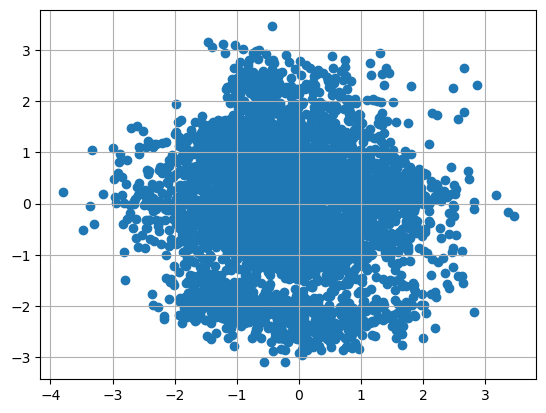

In [79]:
hid = encoder.predict(x_test[:6000], batch_size=batch_size)
plt.scatter(hid[:,0], hid[:,1])
plt.grid()

1/1 [==============================] - 0s 30ms/step


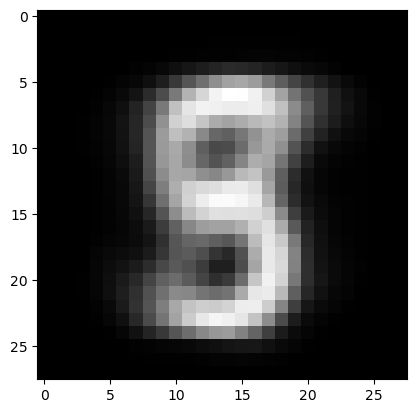

In [82]:
img = decoder.predict(np.expand_dims([-1, 0], axis=0))
plt.imshow(img.squeeze(), cmap='gray')